In [1]:
import classiq
classiq.authenticate()

The current version of 'classiq' has been deprecated, and will not be supported as of 2024-08-31. Please run "pip install -U classiq" to upgrade the classiq SDK to the latest version.
/Users/ar-mohame.karabernou/miniconda3/envs/classiq/lib/python3.9/site-packages/classiq/_internals/authentication/token_manager.py:99: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


In [2]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences

# Quantum Walk Operator design for the case of a line with 16 nodes

A. Following the example from class for creating the quantum walk operator for the case of a circle with 4 nodes, design the quantum walk operator for the case of a line with 16 nodes.

In [3]:
size = 4               # number of qubits to represent 16 vertices
num_nodes = 2**size

## C operator

In [4]:
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
        prob = [0] * num_nodes
        if i == 0:                  # we can't loop around when we are at the edges of the line
            prob[i + 1] = 1.0       # If at the first node, move to the right node (node 1)
        elif i == num_nodes - 1:
            prob[i - 1] = 1.0       # If at the last node, move to the left node (node 14)
        else:
            prob[i - 1] = 0.5       # Probability of moving to the left node
            prob[i + 1] = 0.5       # Probability of moving to the right node
            print(f'Node={i}, prob vec ={prob}')



        control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(num_nodes):
        C_iteration(i,vertices,adjacent_vertices)

## S operator

In [5]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,operand= lambda: bitwise_swap(vertices,adjacent_vertices))

# Quantum Operator (Walk)

In [6]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    allocate(size, vertices)    # Allocating qubits for vertices
    hadamard_transform(vertices)    # Applying Hadamard transform to initialize superposition
    allocate(size, adjacent_vertices)    # Again Allocating qubits for adjacent vertices

    C_operator(vertices, adjacent_vertices)  # Applying The C Operator
    S_operator(vertices, adjacent_vertices)  # Applying  The S Operator

In [7]:
# Create and synthesize the quantum walk operator model
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node=14, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5]
O

## Initialized circuit

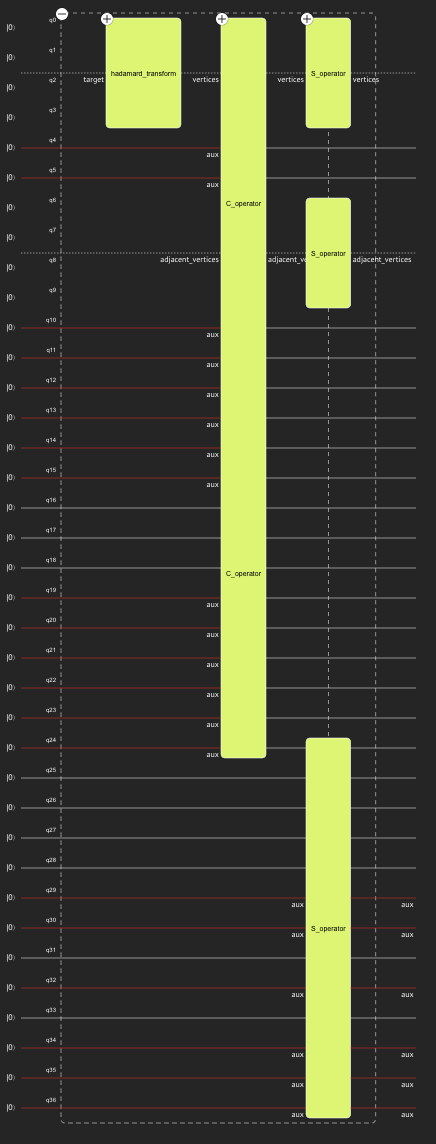

## C operator

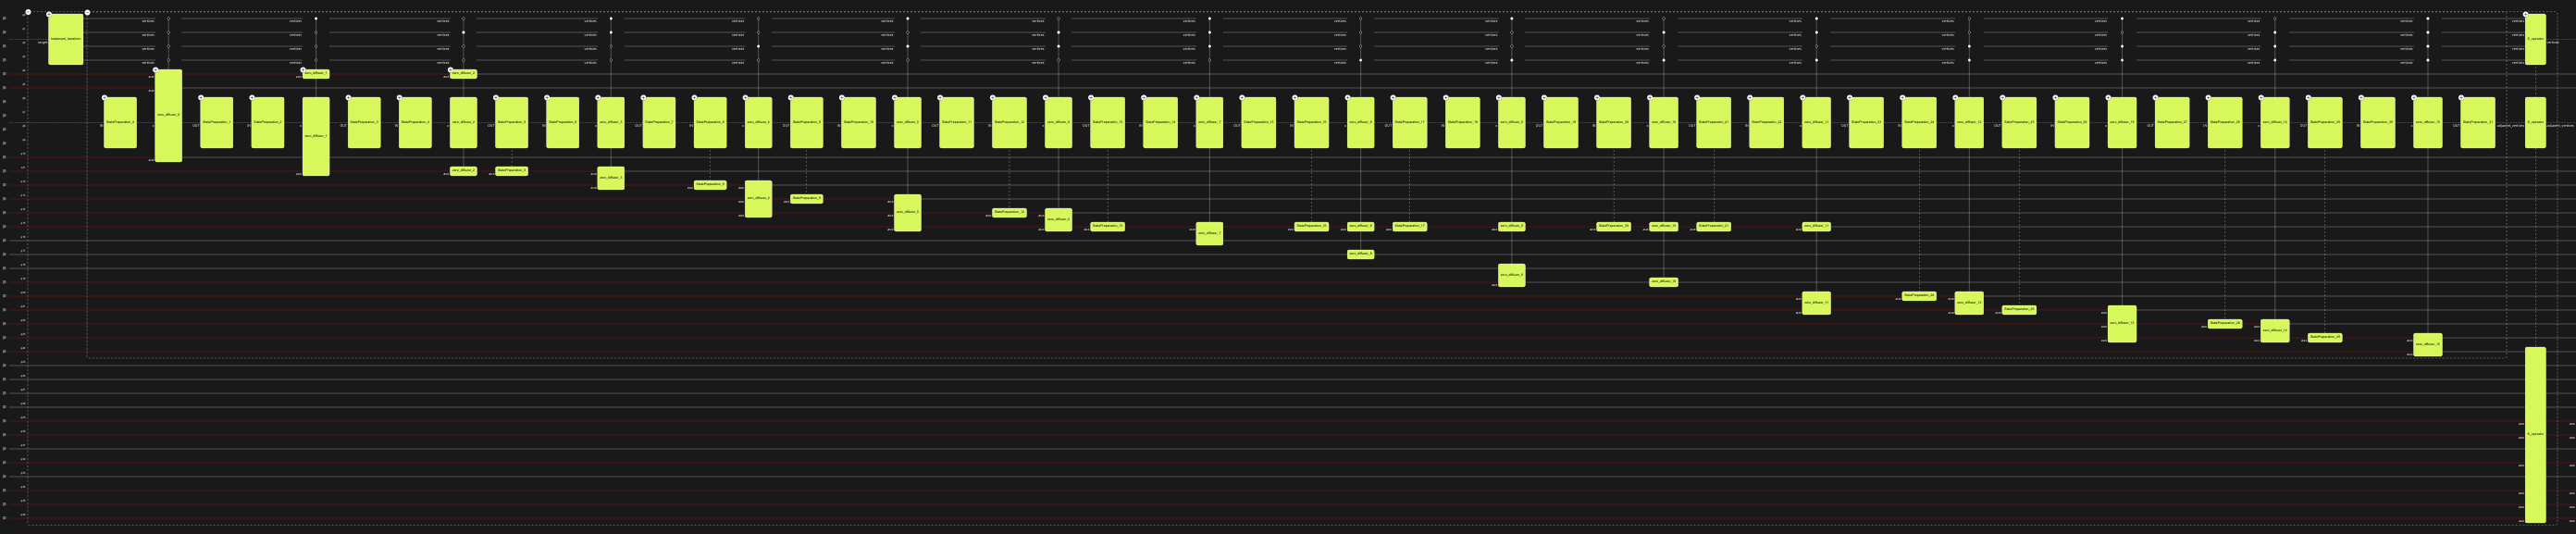

## S operator

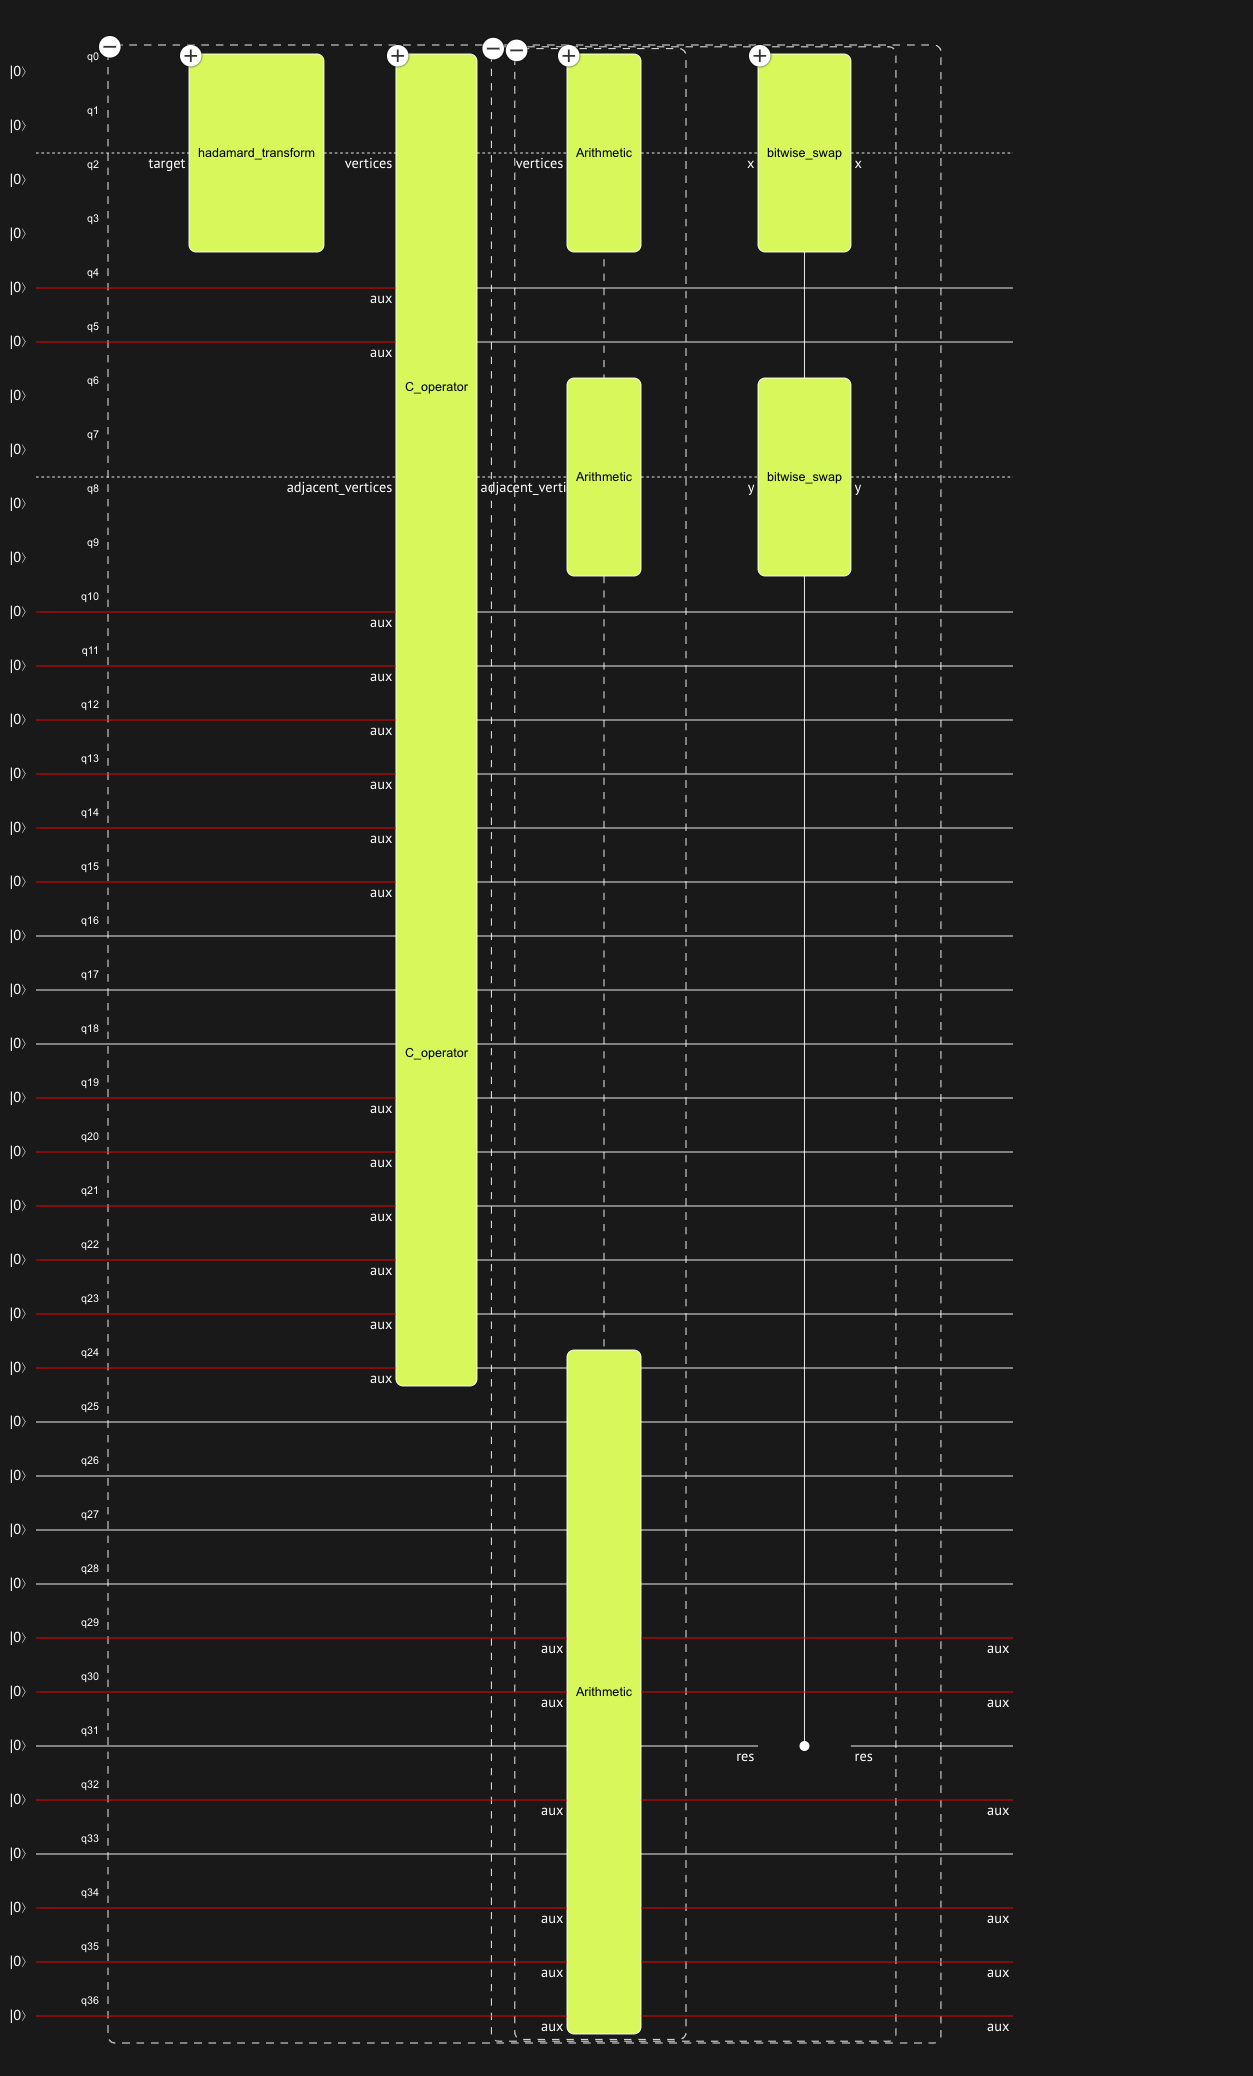